In [54]:
import numpy as np 
import os
import cv2
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.applications.vgg16 import VGG16, preprocess_input

from keras import backend as K
from keras.utils import plot_model
n=224
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
from keras.initializers import Constant

from matplotlib import pyplot as plt
%matplotlib inline

from skimage.morphology import disk
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import jaccard_similarity_score

In [55]:
def FCN8(nClasses, input_height, input_width):

    #-----------------------------------------Define Input and Create VGG Layers---------------------------------------
    img_input = Input(shape=(input_height, input_width, 3))
    vgg = VGG16( weights='imagenet', include_top=False, input_tensor=img_input)


    #----------------------------------------FCN8 for the segmentation-------------------------------------------------
    vgg_out = Conv2D(filters=4096, kernel_size=(7, 7), padding="same", activation="relu", name="fc6")(vgg.output)
#     o = Dropout(rate=0.5)(o)
    
    vgg_out_conv_1 = Conv2D(filters=4096, kernel_size=(1, 1), padding="same", activation="relu", name="fc7")(vgg_out)
#     o = Dropout(rate=0.5)(o)

    vgg_out_conv_2 = Conv2D(filters=nClasses, kernel_size=(1, 1), padding="same", activation="relu", kernel_initializer="he_normal",
               name="score_fr")(vgg_out_conv_1)

    vgg_out_convTR = Conv2DTranspose(filters= nClasses,
                                     kernel_size=(2, 2), 
                                     strides=(2, 2), 
                                     padding="valid", 
                                     activation=None,
#                                      kernel_initializer=Constant(bilinear_upsample_weights(2, nClasses)),
                                     name="score2")(vgg_out_conv_1)

    # Conv to be applied on Pool4
    skip_con1 = Conv2D(nClasses, kernel_size=(1, 1), padding="same", activation=None, kernel_initializer="he_normal",
                       name="score_pool4")(vgg.get_layer("block4_pool").output)
    Skip_1 = add(inputs=[skip_con1, vgg_out_convTR])

    Skip_temp = Conv2DTranspose(nClasses, 
                                kernel_size=(2, 2), 
                                strides=(2, 2), 
                                padding="valid", 
                                activation=None,
#                                 kernel_initializer=Constant(bilinear_upsample_weights(2, nClasses)),
                                name="score4")(Skip_1)

    ###
    skip_con2 = Conv2D(nClasses, kernel_size=(1, 1), padding="same", activation=None, kernel_initializer="he_normal",
                       name="score_pool3")(vgg.get_layer("block3_pool").output)
    Skip_2 = add(inputs=[skip_con2, Skip_temp])

    #####
    fINALlAYER = Conv2DTranspose(nClasses, 
                                 kernel_size=(8, 8), 
                                 strides=(8, 8),
                                 padding="valid", 
                                 activation='relu', 
#                                  kernel_initializer=bilinear_upsample_weights(8, nClasses),
                                 name="upsampling")(Skip_2)

    
#     FCN8 = Conv2D(1, 1, activation = 'sigmoid')(fINALlAYER)

#     modelFCN8 = Model(input = img_input, output = FCN8)

    #............................................................................................................
    
#     modelFCN8.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
#     return modelFCN8
    

    vgg_Base = vgg
    
    deconv_1 = UpSampling2D((2, 2))(vgg_Base.output)
    deconv_1 = concatenate([vgg_Base.get_layer(name="block4_pool").output, deconv_1], axis=-1)
    deconv_1 = Conv2D(512, (3, 3), padding="same")(deconv_1)
    deconv_1 = BatchNormalization()(deconv_1)

    deconv_2 = UpSampling2D((2, 2))(deconv_1)
    deconv_2 = concatenate([vgg_Base.get_layer(name="block3_pool").output, deconv_2], axis=-1)
    deconv_2 = Conv2D(256, (3, 3), padding="same")(deconv_2)
    deconv_2 = BatchNormalization()(deconv_2)

    deconv_3 = UpSampling2D((2, 2))(deconv_2)
    deconv_3 = concatenate([vgg_Base.get_layer(name="block2_pool").output, deconv_3], axis=-1)
    deconv_3 = Conv2D(128, (3, 3), padding="same")(deconv_3)
    deconv_3 = BatchNormalization()(deconv_3)

    deconv_4 = UpSampling2D((2, 2))(deconv_3)
    deconv_4 = concatenate([vgg_Base.get_layer( name="block1_pool").output, deconv_4], axis=-1)
    deconv_4 = Conv2D(64, (3, 3), padding="same")(deconv_4)
    deconv_4 = BatchNormalization()(deconv_4)

    deconv_5 = UpSampling2D((2, 2))(deconv_4)
    deconv_5 = Conv2D(64, (3, 3), padding="same")(deconv_5)
    deconv_5 = BatchNormalization()(deconv_5)

    deconv_6 = Conv2D(nClasses, (1, 1), padding="same")(deconv_5)
    deconv_6 = BatchNormalization()(deconv_6)
    deconv_6 = Activation("relu")(deconv_6)

#     deconv_7 = Reshape((-1, nClasses))(deconv_6)
#     deconv_7 = Activation("softmax")(deconv_7)

#     conv10 = Conv2D(1, 1, activation = 'sigmoid')(deconv_6)

    
    deco6=Average()([deconv_6, fINALlAYER])
    
    conv = Conv2D(1, 1, activation = 'sigmoid')(deco6)
    
    modelUNET = Model(input = img_input, output = conv)


    for layer in modelUNET.layers[:26]:
        layer.trainable = False 


    return modelUNET



In [56]:
def adjustData(img, mask):
#     img = preprocess_input(img)
    img = img/img.max()
    mask = mask/mask.max() 
#     mask[mask > 0.5] = 1
#     mask[mask <= 0.5] = 0
    return (img, mask)

In [57]:
def trainGenerator(batch_size, train_path, image_folder, mask_folder, aug_dict, image_color_mode = "rgb",
                    mask_color_mode = "grayscale", image_save_prefix  = "image", mask_save_prefix  = "mask",
                    save_to_dir = None, target_size = (n,n), seed = 1):
    
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = 'rgb',
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = 'grayscale',
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    
    train_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask)
        yield (img,mask)

In [58]:
def ValGenerator(batch_size, val_path, image_folder, mask_folder, target_size = (n,n), seed = 1):
    
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    
    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()
    
    image_generator = image_datagen.flow_from_directory(
        val_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = 'rgb',
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)

    
    mask_generator = mask_datagen.flow_from_directory(
        val_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = 'grayscale',
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)

    
    val_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in val_generator:
        img,mask = adjustData(img,mask)
        yield (img,mask)

In [59]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, K.sigmoid(y_pred)) + dice_loss(y_true, K.sigmoid(y_pred))

In [60]:
data_gen_args = dict(rotation_range=20,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    shear_range=0.1,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

CurrentDirectory=os.getcwd()

TrainGen= trainGenerator(batch_size=5, train_path=CurrentDirectory+'/Data', image_folder='TrainImage2', mask_folder='TrainGT2',
                       aug_dict=data_gen_args, image_color_mode = "grayscale", mask_color_mode = "grayscale",
                       image_save_prefix  = "image", mask_save_prefix  = "mask", save_to_dir = CurrentDirectory+'/Aug/',
                       target_size = (n,n), seed = 1)


TestGen= ValGenerator(batch_size=5, val_path=CurrentDirectory+'/Data', image_folder='TestImage2', 
                      mask_folder='TestGT2', target_size = (n,n), seed = 1)

model = FCN8(2, n, n)

model.compile(optimizer = 'adadelta',
              loss = bce_dice_loss, 
              metrics = ['accuracy'])

plot_model(model, show_shapes=True, to_file='model_unet.png')
model.summary()

# model_checkpoint = ModelCheckpoint('modelSaved.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

# history=model.fit_generator(TrainGen, 
#                             steps_per_epoch=400, 
#                             epochs=2, 
#                             verbose=1, 
#                             validation_data= TestGen, 
#                             validation_steps=60, 
#                             callbacks=[model_checkpoint])


C:\Users\kamru\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [61]:
# # Plot training & validation accuracy values
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.grid('on')
# plt.show()


# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.grid('on')
# plt.show()

In [62]:
# testGene = CurrentDirectory+'/Data/TestImage2/'
# CurrentDirectory=os.getcwd()
# MaskSavePath= CurrentDirectory+'/Mask/'
# target_size = (n,n)
# imagePath = glob.glob(testGene+"*.png")
# imagePath.sort()
# # print(imagePath)
# kernel=disk(5)
# model = FCN8(2, n, n)
# model.load_weights("modelSaved.hdf5")

# for imageName in imagePath:
#     img = cv2.imread(imageName,-1)
#     filename, file_extension = os.path.splitext(imageName)  
# #     print(img.shape)
# #     plt.figure()
# #     plt.imshow(img)
# #     img = preprocess_input(img)
#     img = trans.resize(img,target_size)
# #     img = preprocess_input(img)
# #     plt.figure()
# #     plt.imshow(img)
    
# #     plt.figure()
# #     plt.imshow(img)
# #     img = np.reshape(img,img.shape+(1,)) 
# #     img = np.reshape(img,(1,)+img.shape)
# #     print(img.shape)
#     img=np.expand_dims(img, axis=0)
#     Pr=model.predict(img,verbose=0)
#     Pr=Pr.reshape(n,n)
#     one=200*Pr
# #     Pr[Pr<0.5]=0
# #     Pr[Pr>=0.5]=255
# #     print(Pr.shape)   
# #     mx=one.max()
# #     mn=one.min()
# #     th=(mx+mn)/2
# #     one[one<th]=0
# #     ret2,th2 = cv2.threshold(one,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     path=MaskSavePath+filename[-4:]+file_extension
#     th=(one.max()+one.min())/2
# #     print(one.min())
# #     T=one.min()+1e-6
# #     one[one<T]=0
# #     one[one>=T]=255
# #     one=one.astype('uint8')
# #     one = cv2.erode(one,kernel,iterations = 1)
# #     one[one!=0]=255
#     cv2.imwrite(path,one)
# #     plt.imshow(th2,cmap='gray')

In [63]:
# testGene = CurrentDirectory+'/Data/TestImage2/'
# CurrentDirectory=os.getcwd()
# MaskSavePath= CurrentDirectory+'/Mask/'
# target_size = (n,n)
# imagePath = glob.glob(testGene+"*.png")
# imagePath.sort()

# kernel=disk(4)
# model = FCN8(2, n, n)
# model.load_weights("modelSaved.hdf5")

# img = cv2.imread(imagePath[1],-1)

# # filename, file_extension = os.path.splitext(imageName)  

# img = img / 255

# img = trans.resize(img,target_size)

# img=np.expand_dims(img, axis=0)
# Pr=model.predict(img,verbose=0)
# Pr=Pr.reshape(n,n)
# print(Pr.shape)
# print(Pr.dtype)
# print(Pr.max())
# print(Pr.min())
# Pr[Pr<0.5]=0
# Pr[Pr>=0.5]=1
# print(Pr.shape)
# print(Pr.dtype)
# print(Pr.max())
# print(Pr.min())

# # mx=one.max()
# # mn=one.min()
# # th=(mx+mn)/2
# # one[one<th]=0
# # ret2,th2 = cv2.threshold(one,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# # path=MaskSavePath+filename[-4:]+file_extension
# # one[one!=0]=255


In [64]:
# CurrentDirectory=os.getcwd()
# PR=CurrentDirectory+'/Mask/'
# GTPath= CurrentDirectory+'/Data/TestGT2/'
# output_path=CurrentDirectory+'/GTPR/'

In [65]:
# OR = glob.glob(PR+"*.png")
# OR.sort()
# print(len(OR))
# GT = glob.glob(GTPath+"*.png")
# GT.sort()
# print(len(GT))

In [66]:
# def compute_iou(y_pred, y_true):
#     # ytrue, ypred is a flatten vector
#     y_pred = y_pred.flatten()
#     y_true = y_true.flatten()
#     cm= confusion_matrix(y_true, y_pred, labels=[0, 1]) # cm means confusion Matrix
#      # compute mean iou
#     intersection = np.diag(cm)
#     ground_truth_set = cm.sum(axis=1)
#     predicted_set = cm.sum(axis=0)
#     union = ground_truth_set + predicted_set - intersection
#     IoU = intersection / union.astype(np.float32)
#     return np.mean(IoU), cm

In [67]:
# def dice(im1, im2, empty_score=1.0):
    
#     """
#     Computes the Dice coefficient, a measure of set similarity.
#     Parameters
#     ----------
#     im1 : array-like, bool
#         Any array of arbitrary size. If not boolean, will be converted.
#     im2 : array-like, bool
#         Any other array of identical size. If not boolean, will be converted.
#     Returns
#     -------
#     dice : float
#         Dice coefficient as a float on range [0,1].
#         Maximum similarity = 1
#         No similarity = 0
#         Both are empty (sum eq to zero) = empty_score
        
#     Notes
#     -----
#     The order of inputs for `dice` is irrelevant. The result will be
#     identical if `im1` and `im2` are switched.
#     """
    
#     im1 = np.asarray(im1).astype(np.bool)
#     im2 = np.asarray(im2).astype(np.bool)

#     if im1.shape != im2.shape:
#         raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

#     im_sum = im1.sum() + im2.sum()
#     if im_sum == 0:
#         return empty_score

#     # Compute Dice coefficient
#     intersection = np.logical_and(im1, im2)

#     return 2. * intersection.sum() / im_sum

In [68]:
# def jaccard(im1, im2, empty_score=1.0):
#     """
#     Computes the Dice coefficient, a measure of set similarity.
#     Parameters
#     ----------
#     im1 : array-like, bool
#         Any array of arbitrary size. If not boolean, will be converted.
#     im2 : array-like, bool
#         Any other array of identical size. If not boolean, will be converted.
#     Returns
#     -------
#     dice : float
#         Dice coefficient as a float on range [0,1].
#         Maximum similarity = 1
#         No similarity = 0
#         Both are empty (sum eq to zero) = empty_score
        
#     Notes
#     -----
#     The order of inputs for `dice` is irrelevant. The result will be
#     identical if `im1` and `im2` are switched.
#     """
#     im1 = np.asarray(im1).astype(np.bool)
#     im2 = np.asarray(im2).astype(np.bool)

#     if im1.shape != im2.shape:
#         raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

#     im_sum = im1.sum() + im2.sum()
#     if im_sum == 0:
#         return empty_score

#     # Compute Dice coefficient
#     intersection = np.logical_and(im1, im2)
#     union = np.logical_or(im1, im2)

#     return intersection.sum() / float(union.sum())

In [69]:
# IU=[]
# Sensitivity=[]
# Specificity=[]
# Accuracy=[]
# BalancedAccuracy=[]
# ROC_AUC=[]
# dicee=[]
# JI=[]

In [70]:
# # Total Number of images should be same as the total number of segmented Mask

# assert len(OR) == len(GT) 

# # kernel=disk(10)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))

# i=5000
# # Checking that every image has their corresponding segmented mask.

# for im , seg in zip(OR,GT):
    
#     Image, _ = os.path.splitext(im)
#     GT,_     = os.path.splitext(seg)
    
#     assert(Image[-4:]   ==  GT[-4:]  )
    
#     pred=cv2.imread(im,0)

#     predicted = cv2.resize(pred, (n, n)) 
    
#     predicted = cv2.erode(predicted,kernel,iterations = 1)
# #     predicted = cv2.morphologyEx(predicted, cv2.MORPH_OPEN, kernel)
#     imGT=cv2.imread(seg,0)
    
#     imGT[imGT!=0]=255

#     imGT = cv2.resize(imGT, (n, n)) 

#     tttt=cv2.merge((predicted,predicted,predicted))
#     tttt[:,:,0]=0
#     tttt[:,:,2]=0


#     plt.figure()
#     plt.imshow(imGT, 'gray', interpolation='none')
#     plt.imshow(tttt, 'jet', interpolation='none', alpha=0.3)
#     plt.xticks([])
#     plt.yticks([])
#     saveName=output_path+'OverLay_'+str(i)+'.png'
#     plt.savefig(saveName, bbox_inches='tight')
#     plt.clf()
#     i=i+1
    
#     dd=dice(predicted,imGT)
#     dicee.append(dd)
    
#     Jscrore=jaccard(predicted,imGT)
#     JI.append(Jscrore)

#     ret,im = cv2.threshold(imGT,250,255,cv2.THRESH_BINARY)
#     im=im/im.max()
#     Predicted=np.array(im).ravel()

#     ret,GT = cv2.threshold(pred,250,255,cv2.THRESH_BINARY)
#     GT=GT/GT.max()
#     GroundTruth=np.array(GT).ravel()
    
#     IoU, ConfusionMatrix=compute_iou(Predicted,GroundTruth)

    
#     IU.append(IoU)
    
#     TN = ConfusionMatrix[0][0]
#     FP = ConfusionMatrix[0][1]
#     FN = ConfusionMatrix[1][0]
#     TP = ConfusionMatrix[1][1]
    
#     temp_Sensitivity=(TP/(TP+FN))
#     Sensitivity.append(temp_Sensitivity)
    
#     temp_Specificity=(TN/(FP+TN))
#     Specificity.append(temp_Specificity)
    
#     temp_Accuracy=((TP+TN)/(TP+TN+FP+FN))
#     Accuracy.append(temp_Accuracy)
    
#     temp_BalancedAccuracy=(temp_Sensitivity+temp_Specificity)/2
#     BalancedAccuracy.append(temp_BalancedAccuracy)
    
#     fpr, tpr, thresholds =roc_curve(GroundTruth, Predicted)
#     roc_auc = auc(fpr, tpr)
#     ROC_AUC.append(roc_auc)
    
    
#     font                   = cv2.FONT_HERSHEY_SIMPLEX
#     bottomLeftCornerOfText = (5,50)
#     fontScale              = 1
#     fontColor              = (0,0,255)
#     lineType               = 2

#     img=cv2.imread(saveName,-1)
#     cv2.putText(img,str(dd), 
#         bottomLeftCornerOfText, 
#         font, 
#         fontScale,
#         fontColor,
#         lineType)
#     saveName2=output_path+'OverLay_'+str(i)+'.jpg'
#     cv2.imwrite(saveName2,img)

In [71]:
# print("DSC = %0.4f (+/-%0.04f)" % (np.mean(dicee)*100, np.std(dicee)*100))
# print("Intersection over Union = %0.4f (+/-%0.04f)" % (np.mean(IU)*100, np.std(IU)*100))
# print("Sensitivity = %0.4f (+/-%0.04f)" % (np.mean(Sensitivity)*100, np.std(Sensitivity)*100))
# print("Specificity = %0.4f (+/-%0.04f)" % (np.mean(Specificity)*100, np.std(Specificity)*100))
# print("Accuracy = %0.8f (+/-%0.04f)" % (np.mean(Accuracy)*100, np.std(Accuracy)*100))
# print("Balanced Accuracy = %0.4f (+/-%0.04f)" % (np.mean(BalancedAccuracy)*100, np.std(BalancedAccuracy)*100))
# print("AUC = %0.4f (+/-%0.04f)" % (np.mean(ROC_AUC)*100, np.std(ROC_AUC)*100))
# print("JI = %0.4f (+/-%0.04f)" % (np.mean(JI)*100, np.std(JI)*100))

In [72]:
# DSC = 83.0834 (+/-18.2871)
# Intersection over Union = 81.9845 (+/-15.4320)
# Sensitivity = 91.0542 (+/-14.3432)
# Specificity = 93.1068 (+/-14.2170)
# Accuracy = 93.01185352 (+/-10.0934)
# Balanced Accuracy = 92.0805 (+/-9.1937)
# AUC = 92.0805 (+/-9.1937)
# JI = 74.2650 (+/-20.8103)

In [73]:
# DSC = 81.0715 (+/-15.6450)
# Intersection over Union = 76.5855 (+/-14.6711)
# Sensitivity = 73.8209 (+/-18.7216)
# Specificity = 96.1745 (+/-11.2689)
# Accuracy = 90.07974243 (+/-10.6796)
# Balanced Accuracy = 84.9977 (+/-9.3809)
# AUC = 84.9977 (+/-9.3809)
# JI = 70.4928 (+/-17.9819)

In [74]:
testGene = CurrentDirectory+'/Data/TestImage2/'
CurrentDirectory=os.getcwd()
MaskSavePath= CurrentDirectory+'/Mask/'
target_size = (n,n)
imagePath = glob.glob(testGene+"*.png")
imagePath.sort()

In [75]:
image=cv2.imread(imagePath[6],-1)

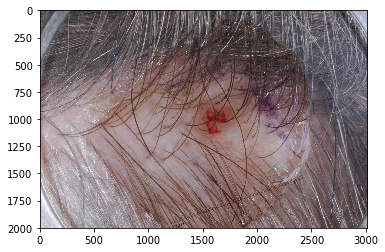

In [76]:
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2000, 3008)
float32


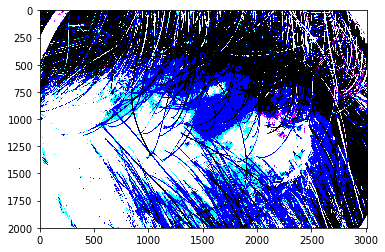

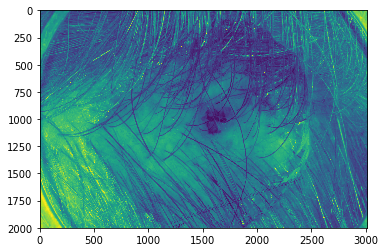

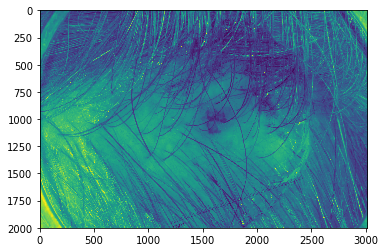

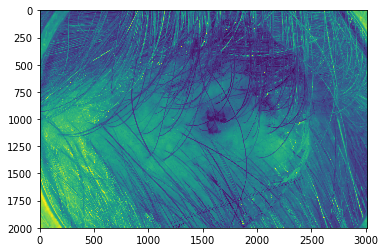

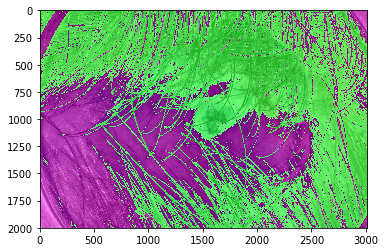

In [77]:
im=preprocess_input(image)
plt.figure()
plt.imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

b,g,r=cv2.split(image)
plt.figure()
plt.imshow(b)

gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(gray)

grayVGG=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(grayVGG)

print(grayVGG.shape)
print(grayVGG.dtype)

grayVGG=grayVGG.astype(np.uint8)

sytheticImage=cv2.merge((b,grayVGG,gray))
plt.figure()
plt.imshow(sytheticImage)

In [78]:
import numpy as np

def boxfilter(img, r):
    (rows, cols) = img.shape
    imDst = np.zeros_like(img)

    imCum = np.cumsum(img, 0)
    imDst[0 : r+1, :] = imCum[r : 2*r+1, :]
    imDst[r+1 : rows-r, :] = imCum[2*r+1 : rows, :] - imCum[0 : rows-2*r-1, :]
    imDst[rows-r: rows, :] = np.tile(imCum[rows-1, :], [r, 1]) - imCum[rows-2*r-1 : rows-r-1, :]

    imCum = np.cumsum(imDst, 1)
    imDst[:, 0 : r+1] = imCum[:, r : 2*r+1]
    imDst[:, r+1 : cols-r] = imCum[:, 2*r+1 : cols] - imCum[:, 0 : cols-2*r-1]
    imDst[:, cols-r: cols] = np.tile(imCum[:, cols-1], [r, 1]).T - imCum[:, cols-2*r-1 : cols-r-1]

    return imDst


def guidedfilter(I, p, r, eps):
    (rows, cols) = I.shape
    N = boxfilter(np.ones([rows, cols]), r)

    meanI = boxfilter(I, r) / N
    meanP = boxfilter(p, r) / N
    meanIp = boxfilter(I * p, r) / N
    covIp = meanIp - meanI * meanP

    meanII = boxfilter(I * I, r) / N
    varI = meanII - meanI * meanI

    a = covIp / (varI + eps)
    b = meanP - a * meanI

    meanA = boxfilter(a, r) / N
    meanB = boxfilter(b, r) / N

    q = meanA * I + meanB
    return q

In [79]:
# I=np.zeros_like(image)
# for i in range(3):
#     I[:,:,i]=guidedfilter(image[:,:,i], image[:,:,i], r=20, eps=1e-4)
# plt.imshow(cv2.cvtColor(I,cv2.COLOR_BGR2RGB))